In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor 
from scipy.stats import skew, kurtosis
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import optuna
from lightgbm import plot_importance
from scipy.stats import entropy
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler

C:\Users\kaan9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_pd = pd.read_parquet("data_trimmed.parquet")

data_pd['magnitude_acc'] = np.sqrt(data_pd['acc_x']**2+data_pd['acc_y']**2+data_pd['acc_z']**2)
data_pd['magnitude_gy'] = np.sqrt(data_pd['gy_x']**2+data_pd['gy_y']**2+data_pd['gy_z']**2)
data_pd['magnitude_mag'] = np.sqrt(data_pd['mag_x']**2+data_pd['mag_y']**2+data_pd['mag_z']**2)

data_pd['genre_coded'] = data_pd['genre'].astype('category').cat.codes

sensor_cols = ['acc_x','acc_y','acc_z','magnitude_acc','gy_x','gy_y','gy_z','magnitude_gy','mag_x','mag_y','mag_z','magnitude_mag']

In [3]:
'''scaled_pd = []
for id in data_pd['subject_id'].unique():
    filtered_pd = data_pd[data_pd['subject_id']==id]
    for col in sensor_cols:
        scaler = StandardScaler()
        col_scaled = scaler.fit_transform(filtered_pd[col].values.reshape(-1,1))
        filtered_pd[col] = col_scaled.reshape(-1)
    scaled_pd.append(filtered_pd)

scaled_pd = pd.concat(scaled_pd)'''

C:\Users\kaan9\AppData\Local\Temp\ipykernel_18364\3416659646.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pd[col] = col_scaled.reshape(-1)
C:\Users\kaan9\AppData\Local\Temp\ipykernel_18364\3416659646.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pd[col] = col_scaled.reshape(-1)
C:\Users\kaan9\AppData\Local\Temp\ipykernel_18364\3416659646.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [3]:
data_list = data_pd.groupby(['subject_id','label','genre_coded'])[['acc_x','acc_y','acc_z','magnitude_acc','gy_x','gy_y','gy_z','magnitude_gy','mag_x','mag_y','mag_z','magnitude_mag']].agg(list).reset_index()

In [13]:
'''def get_windows(x,window_size):
    window_list = []
    for idx in np.arange(window_size,len(x),step=window_size):
        window_list.append(x[idx-window_size:idx])
    return window_list
    
    for col in sensor_cols:
        data_list[col] = data_list[col].apply(lambda x: get_windows(x,300))

    data_list = data_list.explode(sensor_cols)
    '''

In [5]:
for col in sensor_cols:
    data_list[col+'_mean'] = data_list[col].apply(lambda x: np.mean(x))
    data_list[col+'_std'] = data_list[col].apply(lambda x: np.std(x))
    data_list[col+'_min'] = data_list[col].apply(lambda x: np.min(x))
    data_list[col+'_max'] = data_list[col].apply(lambda x: np.max(x))
    data_list[col+'_range'] = data_list[col].apply(lambda x: np.max(x)-np.mean(x))
    data_list[col+'_skew'] = data_list[col].apply(lambda x: skew(x))
    data_list[col+'_kurtosis'] = data_list[col].apply(lambda x: kurtosis(x))

In [6]:
train_subjects = [1,3,5,6]
test_subjects = [0,2]

model_data = data_list.drop(sensor_cols,axis=1)

test_data = model_data[model_data['subject_id'].isin(test_subjects)]
train_data = model_data[model_data['subject_id'].isin(train_subjects)]

In [7]:
def objective(trial):
    
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200,step=10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, step=0.01),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 20, step=1),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 10, step=1),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 10, step=1),
        "min_split_gain": trial.suggest_float("min_split_gain", 0, 5,step=0.1),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9, step=0.1),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 5)
    }
    
    model = LGBMClassifier(objective='multiclass',num_class=4,**param_grid,verbose=-1)

    cv_scores = []

    for val_subject in train_subjects:

        cv_train = train_data[train_data['subject_id']!=val_subject]
        cv_test = train_data[train_data['subject_id']==val_subject]

        X_train = cv_train.drop(['subject_id','label','genre_coded'],axis=1)
        X_test = cv_test.drop(['subject_id','label','genre_coded'],axis=1)
        y_train, y_test = cv_train['genre_coded'], cv_test['genre_coded']

        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        score = f1_score(preds,y_test,average='weighted')
        #score = accuracy_score(preds,y_test)
        cv_scores.append(score)
    
    
    return np.mean(cv_scores)

In [8]:
study = optuna.create_study(study_name="lightgbm", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-06-12 02:15:08,015] A new study created in memory with name: lightgbm
[I 2024-06-12 02:15:08,344] Trial 0 finished with value: 0.6641462703962704 and parameters: {'n_estimators': 90, 'learning_rate': 0.060000000000000005, 'num_leaves': 30, 'max_depth': 8, 'min_child_samples': 4, 'reg_alpha': 2, 'reg_lambda': 3, 'min_split_gain': 1.5, 'subsample': 0.5, 'subsample_freq': 2}. Best is trial 0 with value: 0.6641462703962704.
[I 2024-06-12 02:15:08,483] Trial 1 finished with value: 0.4000000000000001 and parameters: {'n_estimators': 60, 'learning_rate': 0.03, 'num_leaves': 50, 'max_depth': 12, 'min_child_samples': 7, 'reg_alpha': 9, 'reg_lambda': 2, 'min_split_gain': 2.2, 'subsample': 0.8, 'subsample_freq': 1}. Best is trial 0 with value: 0.6641462703962704.
[I 2024-06-12 02:15:08,743] Trial 2 finished with value: 0.4000000000000001 and parameters: {'n_estimators': 180, 'learning_rate': 0.060000000000000005, 'num_leaves': 100, 'max_depth': 6, 'min_child_samples': 1, 'reg_alpha': 4, '

In [9]:

'''best_params = {'n_estimators': 90,
 'learning_rate': 0.05,
 'num_leaves': 50,
 'max_depth': 11,
 'min_child_samples': 9,
 'reg_alpha': 2,
 'reg_lambda': 9,
 'min_split_gain': 2.,
 'subsample': 0.7,
 'subsample_freq': 3}'''


print(study.best_value)


best_params = study.best_params



X_train = train_data.drop(['subject_id','label','genre_coded'],axis=1)
X_test = test_data.drop(['subject_id','label','genre_coded'],axis=1)
y_train, y_test = train_data['genre_coded'], test_data['genre_coded']

model = LGBMClassifier(objective='multiclass',num_class=4,**best_params,verbose=-1)
model.fit(X_train,y_train)
preds = model.predict(X_test)

0.6700757575757575


In [10]:
f1_score(preds,y_test,average='weighted')

0.6553030303030303

In [11]:
accuracy_score(preds,y_test)

0.5833333333333334

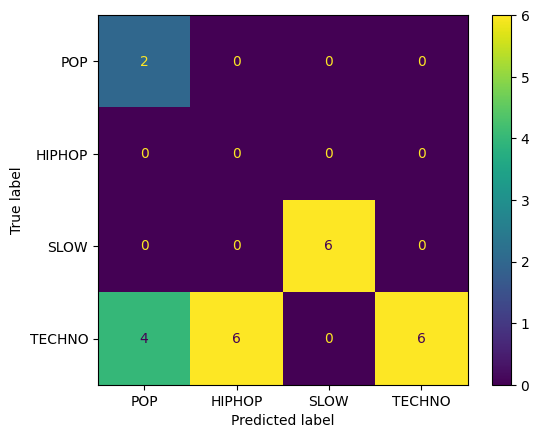

In [12]:
conf_mat = confusion_matrix(preds, y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=['POP','HIPHOP','SLOW','TECHNO'])
disp.plot()
plt.show()